In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader

In [2]:
data: pd.DataFrame = pd.read_csv("data.csv", index_col=0)
print(data.head())

          y        x1        x2        x3        x4        x5        x6  \
0  7.824944 -0.887890  0.949137  0.867185  0.905457 -0.564753  1.064772   
1 -0.284809  0.402109 -0.109812  0.353789 -0.368996  0.484929 -0.872589   
2 -5.551631 -0.114545 -1.603722  0.284455 -0.276847 -1.421414 -1.135600   
3  0.087262  0.832631  0.443724  0.472880  1.260798  0.589971 -0.150165   
4  0.169201  0.318175 -0.042458  0.014656  0.323378  0.425665  0.268726   

         x7        x8        x9       x10  
0  0.871957  0.073367 -0.468684 -1.518201  
1 -0.305881 -0.284581  0.547374 -0.755235  
2 -0.021529 -0.826239  0.647715 -2.370580  
3  1.148314  1.034029 -0.205375 -0.488831  
4  0.177851 -0.128694  0.110501  0.797469  


In [3]:
data_copy = data.copy()
X = data_copy['x1']
y = data_copy['y']
len(y)
X = torch.tensor(X).float()
y = torch.tensor(y).float()


In [4]:
print(X)

tensor([-8.8789e-01,  4.0211e-01, -1.1454e-01,  8.3263e-01,  3.1818e-01,
        -1.1145e+00, -3.3056e-01,  2.7438e-01, -5.8024e-02,  1.8608e-01,
        -6.9900e-01,  2.2576e-01, -6.2765e-01, -3.6806e-01, -4.4978e-01,
        -6.0307e-01, -1.3316e+00,  3.5745e-01, -1.8531e-01, -7.1248e-01,
         5.8778e-02, -9.3345e-01, -1.6907e-01, -3.1073e-01,  9.2514e-01,
         7.8760e-01,  1.5996e+00, -1.3371e-01,  3.9756e-01, -8.2968e-01,
         8.8824e-02,  7.9876e-01, -1.0587e+00,  9.0240e-01, -8.1216e-02,
         4.9702e-01,  6.3034e-01, -3.8779e-01, -1.4474e+00,  1.4125e+00,
         1.1072e+00, -1.1978e+00, -2.9550e+00, -1.4485e+00,  1.8628e-01,
         1.0473e-01,  9.5898e-01,  1.1540e+00, -1.1109e+00, -1.0331e+00,
        -9.6126e-01, -1.4259e+00,  8.1875e-01,  1.5324e+00, -3.2529e-01,
        -1.0262e-01,  1.2790e-01,  5.4728e-01,  5.3777e-01, -1.4584e+00,
         9.5358e-01, -2.1929e-01, -1.4796e+00, -9.1782e-02, -6.8580e-01,
         9.6301e-01, -9.0629e-01, -3.4608e-01, -8.1

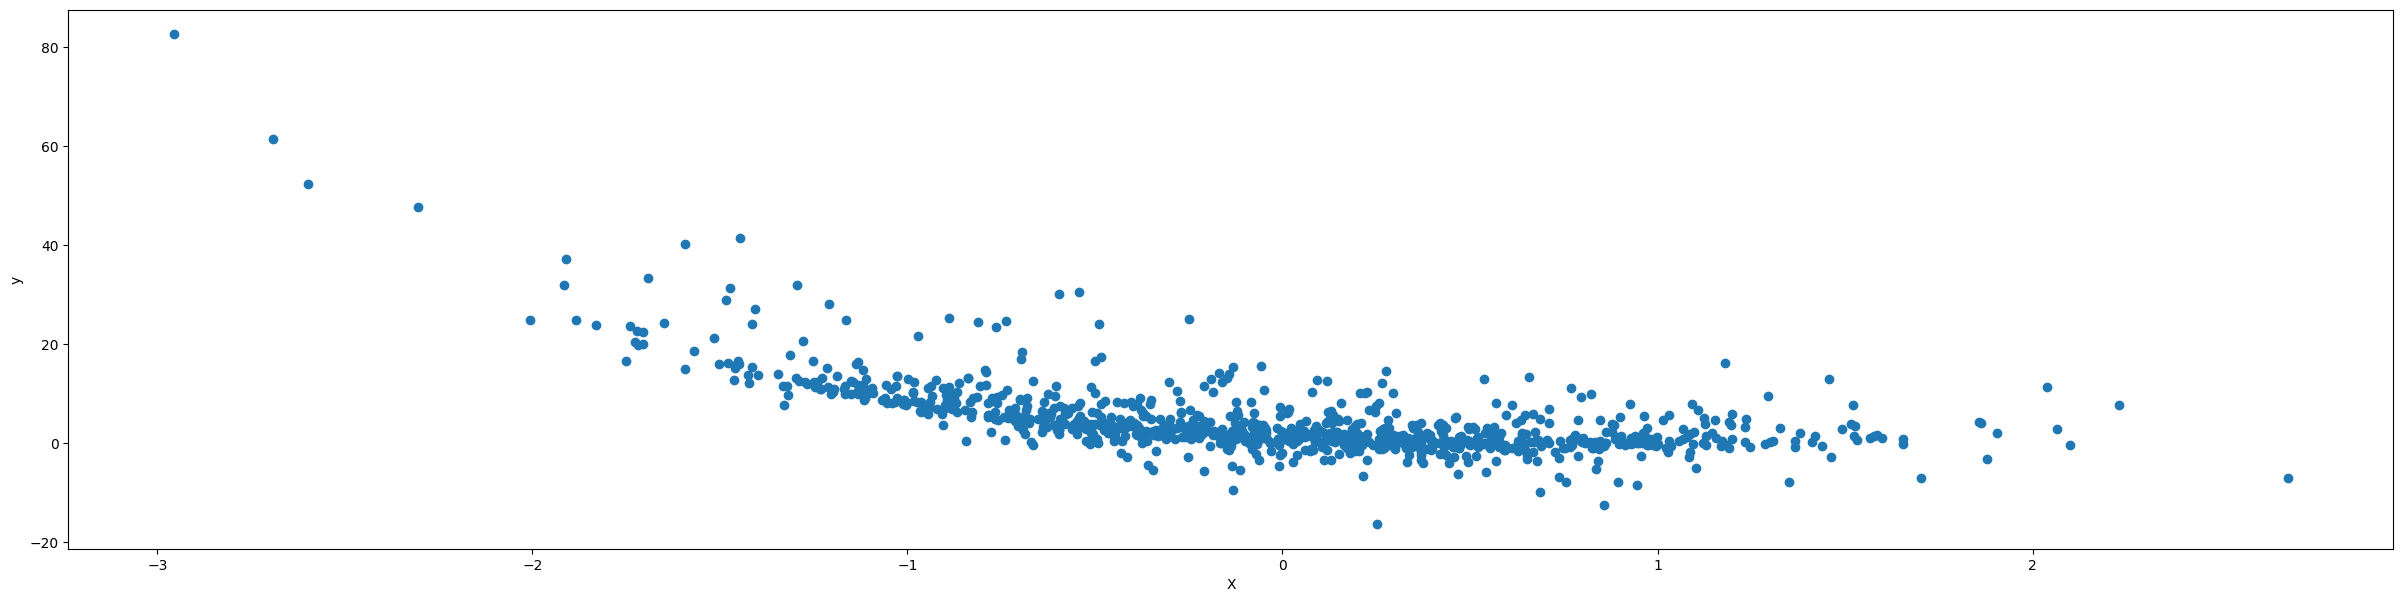

In [5]:
plt.figure(figsize = (30,7))
plt.scatter(X, y)
plt.xlabel("X")
plt.ylabel("y")
plt.show()

In [6]:
def plot_predictions(train_data: torch.Tensor,
                     train_labels: torch.Tensor,
                     test_data: torch.Tensor,
                     test_labels: torch.Tensor,
                     predictions: torch.Tensor = None):
    plt.figure(figsize=(5, 4))

    plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")
    
    plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

    if predictions is not None:
        plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")
        
    plt.legend(prop={"size": 14});

In [7]:
splitter = int(0.8 * len(X))
X_train, X_test = X[:splitter], X[splitter:]
y_train, y_test = y[:splitter], y[splitter:]

print(f"Input Train: {X_train.shape}")
print(f"Input Test: {X_test.shape}")
print(f"Output Train: {y_train.shape}")
print(f"Output Test: {y_test.shape}")

y_test.dtype

Input Train: torch.Size([800])
Input Test: torch.Size([200])
Output Train: torch.Size([800])
Output Test: torch.Size([200])


torch.float32

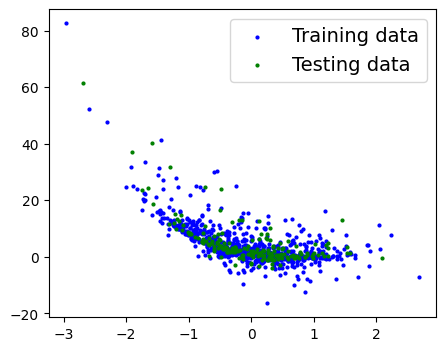

In [8]:
plot_predictions(train_data=X_train, train_labels=y_train, test_data=X_test, test_labels=y_test)

### Model Order Selection

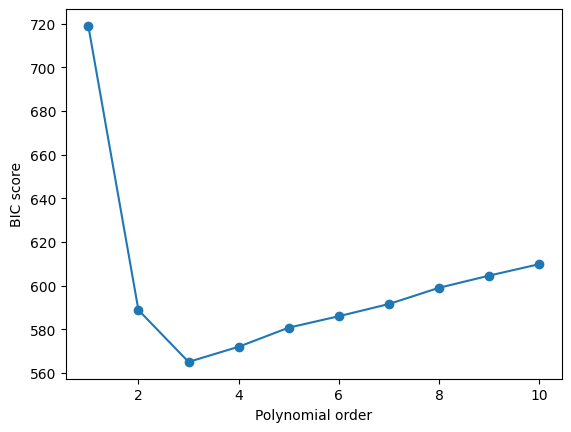

In [9]:
# Define the function to compute the BIC score
def compute_bic(n, k, mse):
    bic = n*np.log(mse) + k*np.log(n)
    return bic
    
# Define the hyperparameters
max_order = 10

# Train and evaluate models with different orders
bic_scores = []
for order in range(1, max_order+1):
    # Fit a linear regression model with polynomial features
    X_train_poly = np.column_stack([X_train**i for i in range(1, order+1)])
    model = LinearRegression().fit(X_train_poly, y_train)
    # Compute the mean squared error on the validation set
    X_test_poly = np.column_stack([X_test**i for i in range(1, order+1)])
    y_test_pred = model.predict(X_test_poly)
    mse = ((y_test - y_test_pred.astype(float))**2).mean()
    
    # Compute the BIC score
    bic = compute_bic(len(X_test), order+1, mse)
    bic_scores.append(bic)

# Plot the BIC scores for different orders
plt.plot(range(1, max_order+1), bic_scores, '-o')
plt.xlabel('Polynomial order')
plt.ylabel('BIC score')
plt.show()

In [10]:
class PolynomialRegressionModel(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.W1 = nn.Parameter(torch.randn(1, # <- start with random weights (this will get adjusted as the model learns)
            requires_grad=True, # <- can we update this value with gradient descent?
            dtype=torch.float # <- PyTorch loves float32 by default
        ))
        self.W2 = nn.Parameter(torch.randn(1, # <- start with random weights (this will get adjusted as the model learns)
            requires_grad=True, # <- can we update this value with gradient descent?
            dtype=torch.float # <- PyTorch loves float32 by default
        ))
        self.bias = nn.Parameter(torch.randn(1, # <- start with random bias (this will get adjusted as the model learns)
            requires_grad=True, # <- can we update this value with gradient descent?
            dtype=torch.float # <- PyTorch loves float32 by default
        ))
    def forward(self, x: torch.Tensor):
        y = self.W1 *x ** 2 + self.W2 * x + self.bias #  as the formula (y = W1 *x **2 + W2 * x + bias)
        return y

In [11]:
def divider():
    print("-----------------------------------")
    
model = PolynomialRegressionModel()
list(model.parameters())
divider()
print(model.state_dict())


-----------------------------------
OrderedDict([('W1', tensor([-0.6143])), ('W2', tensor([0.0084])), ('bias', tensor([-0.3410]))])


In [12]:
with torch.inference_mode():
    y_preds = model(X_test)

print(f"Values: {y_preds}")

Values: tensor([-0.4527, -2.0271, -0.5246, -0.3412, -0.3410, -0.3820, -0.4527, -1.2662,
        -0.3545, -0.4184, -1.6351, -0.3490, -0.4350, -0.7085, -1.1652, -0.6301,
        -0.3716, -0.4949, -0.9420, -0.8470, -0.4739, -0.3410, -0.3799, -0.5026,
        -0.4530, -0.4544, -0.6728, -0.3781, -0.3502, -0.9432, -0.3613, -0.3579,
        -0.3990, -0.9440, -0.5891, -0.3411, -0.7904, -1.2646, -1.1153, -0.3649,
        -1.0862, -0.4741, -0.4162, -0.7084, -0.3939, -0.3494, -0.5238, -0.7087,
        -0.4115, -0.4844, -0.3824, -0.9063, -0.5919, -0.4742, -0.7275, -1.1174,
        -0.6813, -1.9133, -0.5172, -0.9199, -0.3411, -0.6239, -0.4385, -0.3410,
        -0.6245, -0.3986, -0.5613, -0.4061, -0.3604, -0.3649, -0.3719, -0.3551,
        -0.3635, -0.3509, -0.4322, -0.3439, -0.4932, -0.3832, -0.3476, -0.3824,
        -1.2577, -0.3852, -1.2024, -0.3438, -1.7573, -0.3431, -0.3767, -0.3432,
        -0.3413, -0.7228, -0.3559, -0.3543, -0.5492, -1.2698, -0.4926, -0.3837,
        -0.3807, -0.3946, -0.400

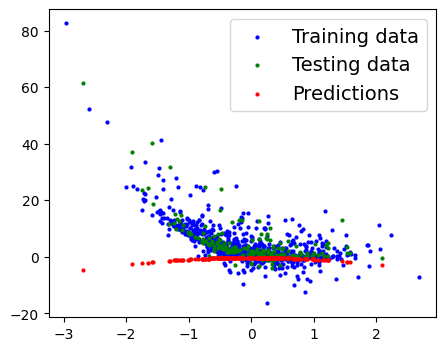

In [13]:
plot_predictions(X_train, y_train, X_test, y_test, y_preds)

In [14]:
loss_function = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.0007)

In [15]:
def train(
        model: nn.Module,
        train_data: torch.Tensor,
        train_labels: torch.Tensor,
        test_data: torch.Tensor,
        test_labels: torch.Tensor,
        loss_function: nn.Module,
        optimizer: torch.optim.Optimizer,
        epochs: int,
    ):
    epochs_count ,train_loss_arr, test_loss_arr = [], [], []
    for epoch in range(epochs+1):
        model.train()
        y_pred = model(train_data)
        loss = loss_function(y_pred, train_labels)
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()

        model.eval()
        with torch.inference_mode():
            y_pred = model(test_data)
            test_loss = loss_function(y_pred, test_labels)

        if epoch % 10 == 0:
            epochs_count.append(epoch)
            train_loss_arr.append(loss.detach().numpy())
            test_loss_arr.append(test_loss.detach().numpy())
            print(f"Epoch {epoch}: MSE Loss: {loss.item():0.2f} | Test Loss: {test_loss.item():0.2f}")
    return epochs_count, train_loss_arr, test_loss_arr

In [16]:
epochs_count, train_loss, test_loss = train(
                                        model, 
                                        train_data=X_train, 
                                        train_labels=y_train, 
                                        test_data=X_test, 
                                        test_labels=y_test, 
                                        loss_function=loss_function, 
                                        optimizer=optimizer, 
                                        epochs=500
                                    )


Epoch 0: MSE Loss: 81.84 | Test Loss: 87.71
Epoch 10: MSE Loss: 79.50 | Test Loss: 85.29
Epoch 20: MSE Loss: 77.26 | Test Loss: 82.98
Epoch 30: MSE Loss: 75.12 | Test Loss: 80.75
Epoch 40: MSE Loss: 73.06 | Test Loss: 78.61
Epoch 50: MSE Loss: 71.09 | Test Loss: 76.56
Epoch 60: MSE Loss: 69.20 | Test Loss: 74.58
Epoch 70: MSE Loss: 67.39 | Test Loss: 72.69
Epoch 80: MSE Loss: 65.65 | Test Loss: 70.86
Epoch 90: MSE Loss: 63.99 | Test Loss: 69.11
Epoch 100: MSE Loss: 62.39 | Test Loss: 67.42
Epoch 110: MSE Loss: 60.86 | Test Loss: 65.80
Epoch 120: MSE Loss: 59.39 | Test Loss: 64.24
Epoch 130: MSE Loss: 57.98 | Test Loss: 62.74
Epoch 140: MSE Loss: 56.63 | Test Loss: 61.30
Epoch 150: MSE Loss: 55.33 | Test Loss: 59.91
Epoch 160: MSE Loss: 54.08 | Test Loss: 58.57
Epoch 170: MSE Loss: 52.89 | Test Loss: 57.28
Epoch 180: MSE Loss: 51.74 | Test Loss: 56.05
Epoch 190: MSE Loss: 50.64 | Test Loss: 54.85
Epoch 200: MSE Loss: 49.58 | Test Loss: 53.70
Epoch 210: MSE Loss: 48.57 | Test Loss: 52.60

In [17]:
def plot_stats(
        epochs: list,
        train_loss: list,
        test_loss: list,
    ):
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_loss, label='Train loss')
    plt.plot(epochs, test_loss, label='Test loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

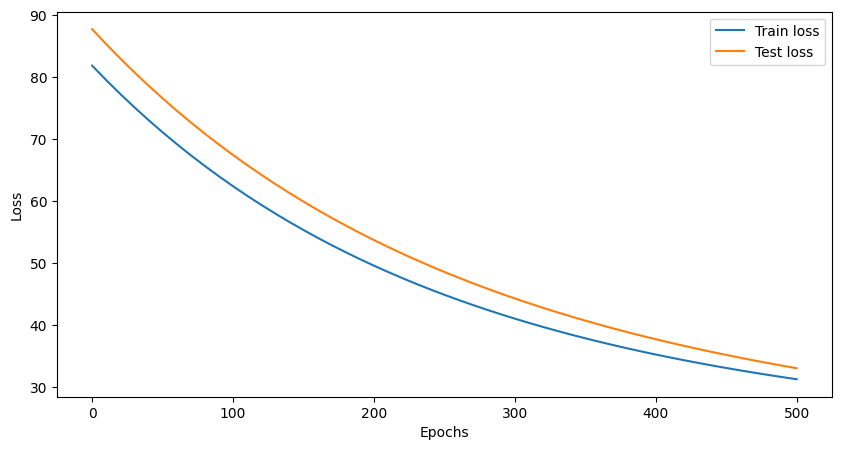

In [18]:
plot_stats(epochs_count, train_loss, test_loss)

In [19]:
def predict(model, X):
    with torch.inference_mode():
        y_pred = model(X)
        return y_pred

In [20]:
y_preds = predict(model, X_test)

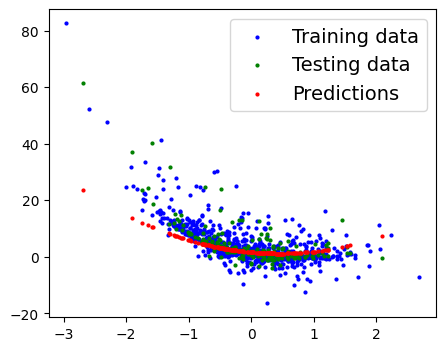

In [21]:
plot_predictions(
    train_data=X_train,
    train_labels=y_train,
    test_data=X_test,
    test_labels=y_test,
    predictions=y_preds,
)

In [22]:
print(f"Model Parameters: {model.state_dict()}")

Model Parameters: OrderedDict([('W1', tensor([2.2616])), ('W2', tensor([-2.0444])), ('bias', tensor([1.6106]))])
